<a href="https://colab.research.google.com/github/linhlinhle997/text2image-dcgan-bert/blob/develop/text2image_dcgan_berts_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
!unzip cvpr2016_flowers.zip

In [ ]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sentence_transformers import SentenceTransformer

## Load Dataset

In [ ]:
CAPTIONS_FOLDER = "/kaggle/working/content/cvpr2016_flowers/captions"
IMG_FOLDER = "/kaggle/working/content/cvpr2016_flowers/images"

In [ ]:
def load_captions(captions_folder, img_folder):
    captions = {}
    img_files = os.listdir(img_folder)

    for img_file in img_files:
        img_name = img_file.split(".")[0]
        caption_file = os.path.join(captions_folder, img_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if img_name not in captions:
            captions[img_name] = caption
    return captions


captions = load_captions(CAPTIONS_FOLDER, IMG_FOLDER)

dict(list(captions.items())[:5])

{'image_00842': 'this star-shaped flower has five petals that are mostly white with yellow closer towards the pistil, which remains unseen.',
 'image_07919': 'flower has petals that are red with yellow tips and red centers.',
 'image_06191': 'the petals of this flower are purple with a long stigma',
 'image_01153': 'this flower has bright orange petals as its main feature',
 'image_07338': 'the petals on this flower are pink, yellow and bell shaped.'}

## Preprocessing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

In [ ]:
def encode_captions(captions):
    encoded_captions = {}
    for img_name in captions.keys():
        caption = captions[img_name]
        encoded_captions[img_name] = {
            "caption": caption,
            "encoded_caption": torch.tensor(bert_model.encode(caption))
        }
    return encoded_captions


encoded_captions = encode_captions(captions)

dict(list(encoded_captions.items())[:2])

In [ ]:
class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.captions = captions
        self.img_names = list(self.captions.keys())
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        caption = self.captions[img_name]["caption"]
        encoded_caption = self.captions[img_name]["encoded_caption"]

        # Select a wrong image
        wrong_idx = np.random.choice([i for i in range(len(self.img_names)) if i != idx])
        wrong_img_name = self.img_names[wrong_idx]
        wrong_img_path = os.path.join(self.img_dir, wrong_img_name + ".jpg")
        wrong_img = Image.open(wrong_img_path).convert("RGB")

        if self.transform:
            wrong_img = self.transform(wrong_img)

        return {
            "image": img,
            "caption": caption,
            "embed_caption": encoded_caption,
            "wrong_image": wrong_img
        }

In [ ]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = FlowerDataset(
    img_dir=IMG_FOLDER,
    captions=encoded_captions,
    transform=transform
)

len(dataset)

8189

In [ ]:
BATCH_SIZE = 128

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

len(dataloader)

64

In [ ]:
batch_sample = next(iter(dataloader))
batch_sample

{'image': tensor([[[[-0.8667, -0.8667, -0.8667,  ..., -0.6863, -0.7020, -0.7412],
           [-0.8275, -0.8510, -0.8510,  ..., -0.7490, -0.8039, -0.8431],
           [-0.7725, -0.8353, -0.8510,  ..., -0.9059, -0.9294, -0.9294],
           ...,
           [-0.6863, -0.7804, -0.7882,  ..., -0.7961, -0.8510, -0.8667],
           [-0.7020, -0.7255, -0.7569,  ..., -0.8118, -0.8588, -0.8902],
           [-0.6863, -0.6863, -0.7176,  ..., -0.7882, -0.8196, -0.8431]],
 
          [[-0.8667, -0.8824, -0.9059,  ..., -0.5922, -0.6000, -0.6314],
           [-0.8196, -0.8588, -0.8902,  ..., -0.6392, -0.7020, -0.7569],
           [-0.7647, -0.8431, -0.8824,  ..., -0.7961, -0.8431, -0.8745],
           ...,
           [-0.7020, -0.8118, -0.8196,  ..., -0.8118, -0.8510, -0.8588],
           [-0.7490, -0.7882, -0.8118,  ..., -0.8118, -0.8510, -0.8980],
           [-0.7647, -0.7647, -0.7961,  ..., -0.7804, -0.8196, -0.8588]],
 
          [[-0.9686, -0.9373, -0.9294,  ..., -0.8980, -0.8824, -0.8902],
    

## Model

### Generator

The Generator block creates an image from the input text.

1. **input**: A random `noise vector` (R) is concatenated with a `text embedding vector` (D), forming an input of size R + D.

2. **Output**: The Generator produces an image with dimensions `C × W × H` (e.g., 3 × 64 × 64 for an RGB image).

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        # Text feature extraction (MLP)
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size), # (B, 768 (BERT)) -> (B, reduced_dim_size)
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Upsampling block to generate images
        self.upSamplingBlock = nn.Sequential(
            # (B, 100 (noise_size) + 256 (reduced_dim_size), 1, 1) -> (B, 1024, 4, 4)
            nn.ConvTranspose2d(noise_size+reduced_dim_size, feature_size*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # (B, 1024, 4, 4) -> (B, 512, 8, 8)
            nn.ConvTranspose2d(feature_size*8, feature_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size*4),
            nn.ReLU(True),

            # (B, 512, 8, 8) -> (B, 256, 16, 16)
            nn.ConvTranspose2d(feature_size*4, feature_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU(True),

            # (B, 256, 16, 16) -> (B, 128, 32, 32)
            nn.ConvTranspose2d(feature_size*2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # (B, 128, 32, 32) -> (B, 128, 64, 64)
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # (B, 128, 64, 64) -> (B, 3, 128, 128)
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh() # Normalize output to [-1, 1]
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings) # (B, reduced_dim_size)

        # Concatenate noise (100) and encoded text (256), reshape for ConvTranspose2d
        concat_input = torch.cat([noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2) # (B, 356) -> (B, 356, 1) -> (B, 356, 1, 1) (B, C, H, W)

        # Generate image
        output = self.upSamplingBlock(concat_input) # (B,3,128,128)
        return output

### Discrimminator

The Discriminator predicts whether an image is Fake or Real using CNN layers:

1. **Input**: Takes an `image matrix` (C × H × W) and a `text embedding`. The image passes through CNN layers to extract features, then is concatenated with the embedding vector.
2. **Output**: The `final vecto`r is used to predict 0 (Fake) or 1 (Real).

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        # Image feature extraction (CNN layers)
        self.imageEncoder = nn.Sequential(
            # (B, 3, 128, 128) -> (B, 128, 64, 64)
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # (B, 128, 64, 64) -> (B, 128, 32, 32)
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # (B, 128, 32, 32) -> (B, 256, 16, 16)
            nn.Conv2d(feature_size, feature_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # (B, 256, 16, 16) -> (B, 512, 8, 8)
            nn.Conv2d(feature_size*2, feature_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # (B, 512, 8, 8) -> (B, 1024, 4, 4)
            nn.Conv2d(feature_size*4, feature_size*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        # Text feature extraction (MLP)
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size), # (B, embedding_size) -> (B, reduced_dim_size)
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Final classification layer
        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size*8+reduced_dim_size, 1, 4, 1, 0, bias=False), # (B, 1024 + reduced_dim_size, 4, 4) -> (B, 1, 1, 1)
            nn.Sigmoid() # Normalize to (0,1)
        )

    def forward(self, input_img, text_embeddings):
        img_encoded = self.imageEncoder(input_img)  # (B, 1024, 4, 4)
        encoded_text = self.textEncoder(text_embeddings) # (B, reduced_dim_size)

        # Expand text embedding to match image feature map size
        replicated_text = encoded_text.repeat(4, 4, 1, 1).permute(2, 3, 0, 1) # (B, reduced_dim_size) -> (B, reduced_dim_size, 4, 4)

        # Concatenate image and text features
        concat_layer = torch.cat([img_encoded, replicated_text], dim=1) # (B, 1024 + reduced_dim_size, 4, 4)

        # Predict real (1) or fake (0)
        x = self.finalBlock(concat_layer) # (B, 1, 1, 1)
        return x.view(-1, 1), img_encoded # Output: (B, 1), (B, 1024, 4, 4)

## Training

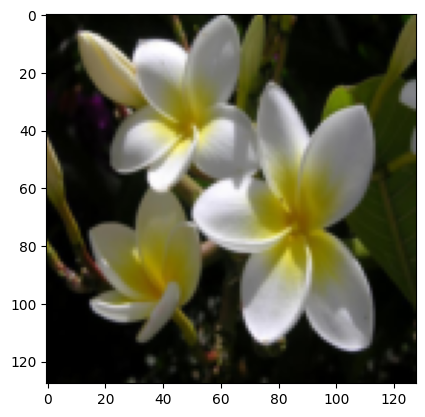

In [ ]:
def show_grid(img):
    """Displays a grid of images."""
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

show_grid(torchvision.utils.make_grid(dataset[0]["image"], normalize=True))

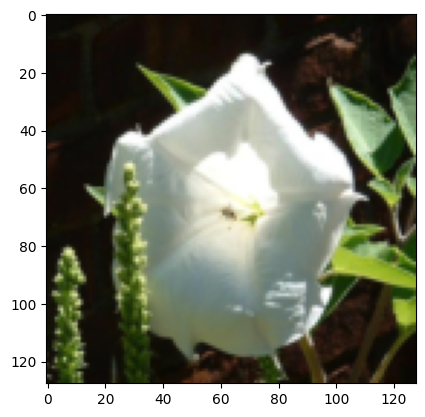

In [ ]:
show_grid(torchvision.utils.make_grid(dataset[0]["wrong_image"], normalize=True))

In [ ]:
@torch.no_grad()
def plot_output(generator, plt_o_text_embeddings, fixed_noise):
    """Generates images using the trained generator and displays them."""
    plt.clf()
    generator.eval()

    # Generate images using fixed noise and text embeddings
    test_images = generator(
        fixed_noise.to(device),
        plt_o_text_embeddings.to(device)
    )

    # Switch back to training mode
    generator.train()

    # Create image grid and show it
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)


In [ ]:
plt_o_text_embeddings = dataset[0]['embed_caption'].unsqueeze(0)
fixed_noise = torch.randn(size=(1, 100))

plt_o_text_embeddings.shape, fixed_noise.shape

(torch.Size([1, 768]), torch.Size([1, 100]))

In [ ]:
generator = Generator(
    noise_size=100,
    feature_size=64,
    num_channels=3,
    embedding_size=768,
    reduced_dim_size=256
).to(device)

discriminator = Discriminator(
    num_channels=3,
    feature_size=128,
    embedding_size=768,
    reduced_dim_size=256
).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

Epoch [1/50 | Loss_D: 1.9808 - Loss_G: 3.8755 - time: 172.81]
Epoch [2/50 | Loss_D: 1.7472 - Loss_G: 2.5594 - time: 173.20]
Epoch [3/50 | Loss_D: 1.7635 - Loss_G: 2.4376 - time: 173.29]
Epoch [4/50 | Loss_D: 1.7804 - Loss_G: 2.2631 - time: 173.29]
Epoch [5/50 | Loss_D: 1.7569 - Loss_G: 2.3937 - time: 172.93]
Epoch [6/50 | Loss_D: 1.7593 - Loss_G: 2.3737 - time: 172.97]
Epoch [7/50 | Loss_D: 1.7649 - Loss_G: 2.4525 - time: 172.75]
Epoch [8/50 | Loss_D: 1.7745 - Loss_G: 2.2966 - time: 174.72]
Epoch [9/50 | Loss_D: 1.8097 - Loss_G: 2.2376 - time: 176.88]


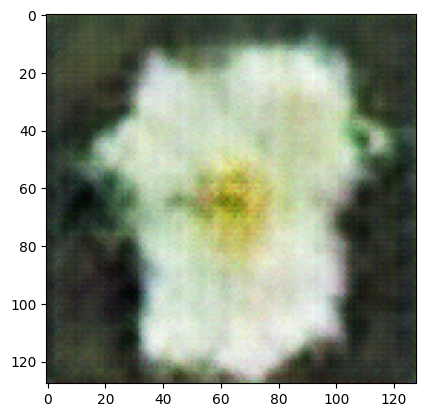

Epoch [10/50 | Loss_D: 1.7568 - Loss_G: 2.2425 - time: 175.64]
Epoch [11/50 | Loss_D: 1.7883 - Loss_G: 2.3106 - time: 174.89]
Epoch [12/50 | Loss_D: 1.7701 - Loss_G: 2.2696 - time: 175.09]
Epoch [13/50 | Loss_D: 1.7956 - Loss_G: 2.2943 - time: 174.87]
Epoch [14/50 | Loss_D: 1.7459 - Loss_G: 2.3284 - time: 175.26]
Epoch [15/50 | Loss_D: 1.7889 - Loss_G: 2.2051 - time: 174.92]
Epoch [16/50 | Loss_D: 1.7557 - Loss_G: 2.3964 - time: 173.73]
Epoch [17/50 | Loss_D: 1.7544 - Loss_G: 2.3560 - time: 173.06]
Epoch [18/50 | Loss_D: 1.7809 - Loss_G: 2.4377 - time: 173.40]
Epoch [19/50 | Loss_D: 1.7174 - Loss_G: 2.3980 - time: 172.49]


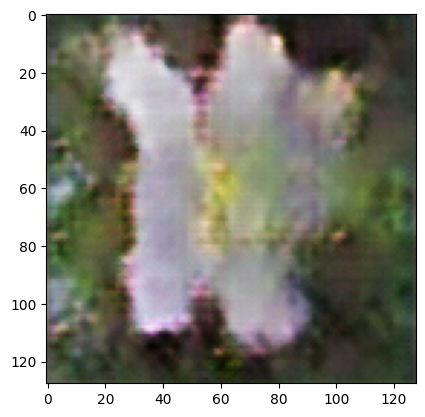

Epoch [20/50 | Loss_D: 1.7727 - Loss_G: 2.4172 - time: 173.96]
Epoch [21/50 | Loss_D: 1.7196 - Loss_G: 2.4587 - time: 173.72]
Epoch [22/50 | Loss_D: 1.7380 - Loss_G: 2.5373 - time: 174.08]
Epoch [23/50 | Loss_D: 1.7221 - Loss_G: 2.4882 - time: 173.38]
Epoch [24/50 | Loss_D: 1.7241 - Loss_G: 2.5285 - time: 172.83]
Epoch [25/50 | Loss_D: 1.7248 - Loss_G: 2.5351 - time: 172.12]
Epoch [26/50 | Loss_D: 1.7120 - Loss_G: 2.5389 - time: 173.55]
Epoch [27/50 | Loss_D: 1.7581 - Loss_G: 2.5155 - time: 172.46]
Epoch [28/50 | Loss_D: 1.6837 - Loss_G: 2.4802 - time: 172.77]
Epoch [29/50 | Loss_D: 1.7045 - Loss_G: 2.5880 - time: 172.94]


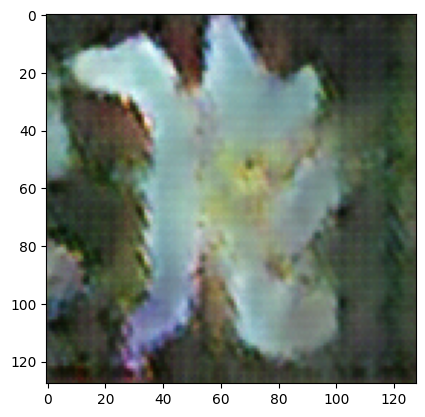

Epoch [30/50 | Loss_D: 1.7264 - Loss_G: 2.4493 - time: 173.22]
Epoch [31/50 | Loss_D: 1.7265 - Loss_G: 2.5796 - time: 172.73]
Epoch [32/50 | Loss_D: 1.6829 - Loss_G: 2.5317 - time: 173.44]
Epoch [33/50 | Loss_D: 1.6958 - Loss_G: 2.5857 - time: 172.32]
Epoch [34/50 | Loss_D: 1.6978 - Loss_G: 2.5561 - time: 179.67]
Epoch [35/50 | Loss_D: 1.7179 - Loss_G: 2.6247 - time: 174.74]
Epoch [36/50 | Loss_D: 1.6709 - Loss_G: 2.5768 - time: 173.12]
Epoch [37/50 | Loss_D: 1.6730 - Loss_G: 2.6091 - time: 173.10]
Epoch [38/50 | Loss_D: 1.7266 - Loss_G: 2.5043 - time: 172.86]
Epoch [39/50 | Loss_D: 1.6729 - Loss_G: 2.5503 - time: 172.90]


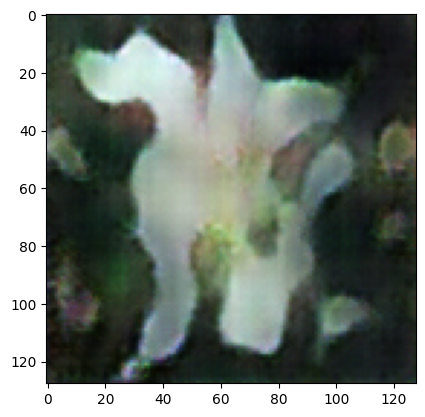

Epoch [40/50 | Loss_D: 1.6849 - Loss_G: 2.5469 - time: 172.57]
Epoch [41/50 | Loss_D: 1.7011 - Loss_G: 2.5341 - time: 172.18]
Epoch [42/50 | Loss_D: 1.6970 - Loss_G: 2.5117 - time: 172.30]
Epoch [43/50 | Loss_D: 1.6919 - Loss_G: 2.5331 - time: 172.41]
Epoch [44/50 | Loss_D: 1.6915 - Loss_G: 2.4489 - time: 173.27]
Epoch [45/50 | Loss_D: 1.6893 - Loss_G: 2.5035 - time: 172.62]
Epoch [46/50 | Loss_D: 1.6825 - Loss_G: 2.5293 - time: 172.65]
Epoch [47/50 | Loss_D: 1.6852 - Loss_G: 2.5610 - time: 172.87]
Epoch [48/50 | Loss_D: 1.6598 - Loss_G: 2.5662 - time: 172.89]
Epoch [49/50 | Loss_D: 1.6936 - Loss_G: 2.4739 - time: 173.05]


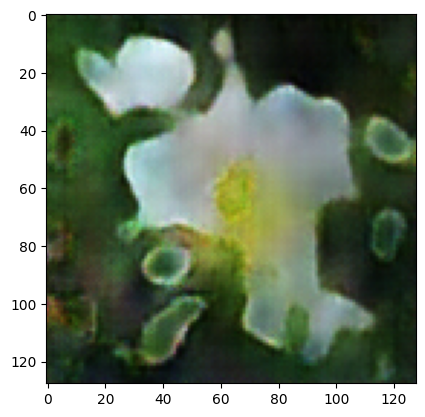

Epoch [50/50 | Loss_D: 1.6849 - Loss_G: 2.5072 - time: 172.82]


In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
    d_losses, g_losses = [], []
    epoch_time = time.time()

    for batch in dataloader:
        images = batch["image"].to(device)
        embed_captions = batch["embed_caption"].to(device)
        wrong_images = batch["wrong_image"].to(device)

        # Labels for real and fake images
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        # Generate fake images
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        # Compute real loss
        outputs, _ = discriminator(images, embed_captions)
        real_loss = bce_loss(outputs, real_labels)

        # Compute contrastive loss for wrong image
        outputs, _ = discriminator(wrong_images, embed_captions)
        wrong_loss = bce_loss(outputs, fake_labels)

        # Compute fake loss
        outputs, _ = discriminator(fake_images.detach(), embed_captions)
        fake_loss = bce_loss(outputs, fake_labels)

        # Compute total discriminator loss
        d_loss = real_loss + fake_loss + wrong_loss
        d_loss.backward()
        optimizer_D.step()

        # Store loss for logging
        d_losses.append(d_loss.item())

         # ---- Train Generator ----
        optimizer_G.zero_grad()

        # Generate fake images again
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        # Compute generator loss
        outputs, fake_features = discriminator(fake_images, embed_captions)
        _, real_features = discriminator(images, embed_captions)

        activation_fake = torch.mean(fake_features, 0)
        activation_real = torch.mean(real_features, 0)

        # Compute loss
        real_loss = bce_loss(outputs, real_labels)
        l2 = l2_loss(activation_fake, activation_real.detach())
        l1 = l1_loss(fake_images, images)

        g_loss = real_loss + 100 * l2 + 50 * l1
        g_loss.backward()
        optimizer_G.step()

        # Store loss for logging
        g_losses.append(real_loss.item())

    # Compute average losses for the epoch
    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)

    # Plot generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        plot_output(generator, plt_o_text_embeddings, fixed_noise)

    print(f"Epoch [{epoch+1}/{EPOCHS} | Loss_D: {avg_d_loss:.4f} - Loss_G: {avg_g_loss:.4f} - time: {(time.time() - epoch_time):.2f}]")

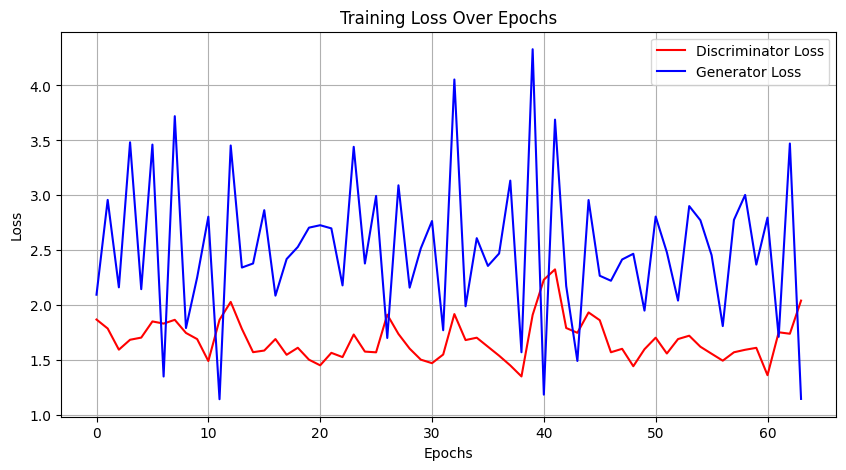

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
MODEL_SAVE_PATH = "./save_model"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save trained model weights
torch.save(generator.state_dict(), os.path.join(MODEL_SAVE_PATH, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(MODEL_SAVE_PATH, "discriminator.pth"))

## Prediction

Caption: this flower is pink and white in color, with petals that are striped.


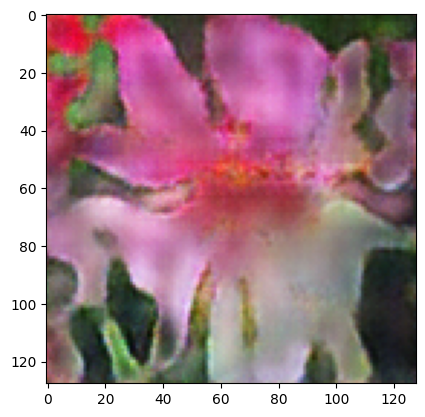

In [ ]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = dataset[10]["embed_caption"].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))

grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)

print(f"Caption: {dataset[10]['caption']}")
show_grid(grid)